In [1]:
from astropy.io import ascii
from regions import CircleSkyRegion
from astropy.table import QTable, Table, Column
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astropy.coordinates import Angle, Latitude, Longitude
from astropy import units as u
from astropy.table import Table, Column, join
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import regions
import re
#from regions import DS9Parser
from astropy.table import vstack
from astropy.io import fits
import warnings
from astropy.wcs import WCS
from uncertainties import ufloat
from uncertainties.umath import *
from radio_beam import Beam
from uncertainties import unumpy
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'lines.linewidth': 2})

Removed 198 sources for the complete catalog
Removed 9 sources for the medium catalog
Removed 81 sources for the robust catalog
Removed 186 sources for the complete catalog
Removed 7 sources for the medium catalog
Removed 47 sources for the robust catalog
Removed 203 sources for the complete catalog
Removed 6 sources for the medium catalog
Removed 58 sources for the robust catalog
Removed 203 sources for the complete catalog
Removed 8 sources for the medium catalog
Removed 32 sources for the robust catalog
Removed 198 sources for the complete catalog
Removed 9 sources for the medium catalog
Removed 81 sources for the robust catalog
Removed 186 sources for the complete catalog
Removed 7 sources for the medium catalog
Removed 47 sources for the robust catalog
Removed 203 sources for the complete catalog
Removed 6 sources for the medium catalog
Removed 58 sources for the robust catalog
Removed 203 sources for the complete catalog
Removed 8 sources for the medium catalog
Removed 32 sources

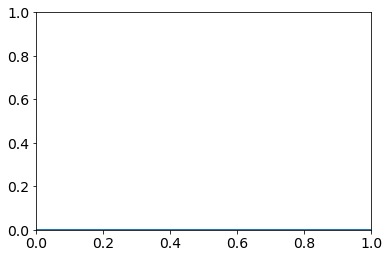

In [2]:
%run Noise_vs_radius.ipynb

In [3]:
path = '/orange/adamginsburg/sgrb2/NB/catalog_the_end/'

In [4]:
base = '/orange/adamginsburg/sgrb2/NB/catalog_the_end/'
catNB3 = Table.read(base+'catalog_NB3_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catMB3 = Table.read(base+'catalog_MB3_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catNB6 = Table.read(base+'catalog_NB6_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catMB6 = Table.read(base+'catalog_MB6_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
from purify_catalog import cat_purification
from purify_catalog import cat_purification_cores
from purify_catalog import HII_catalogs
#cat_NB3_HII_candidates, cat_MB3_HII_candidates, cat_NB3_HII, cat_MB3_HII, cat_NB6_HII_candidates, cat_MB6_HII_candidates, cat_NB6_HII, cat_MB6_HII = HII_catalogs(catNB3, catNB6, catMB3, catMB6)
catNB3_m, catMB3_m, catNB6_m, catMB6_m = cat_purification_cores(catNB3, catMB3, catNB6, catMB6)
catNB3_HII, catNB3_HII_cand, catNB3_HII_new, catMB3_HII, catMB3_HII_cand, catMB3_HII_new, catNB6_HII, catNB6_HII_cand, catNB6_HII_new, catMB6_HII, catMB6_HII_cand, catMB6_HII_new = HII_catalogs(catNB3, catNB6, catMB3, catMB6)

Removed 198 sources for the complete catalog
Removed 9 sources for the medium catalog
Removed 81 sources for the robust catalog
Removed 186 sources for the complete catalog
Removed 7 sources for the medium catalog
Removed 47 sources for the robust catalog
Removed 203 sources for the complete catalog
Removed 6 sources for the medium catalog
Removed 58 sources for the robust catalog
Removed 203 sources for the complete catalog
Removed 8 sources for the medium catalog
Removed 32 sources for the robust catalog


In [5]:
def read_in(path):
    """
    Simplify reading in the files.
    """
    fh=fits.open(path)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        wcs = WCS(fh[0].header)
        hdr = fh[0].header
    datas=fh[0].data #
    return datas, wcs, hdr

In [6]:
base = '/orange/adamginsburg/sgrb2/NB/the_end/'
pathNB3 = base+'sgr_b2.N.B3.cont.r0.5.1m0.075mJy.cal2.image.tt0.pbcor.fits'
pathMB3 = base+'sgr_b2.M.B3.cont.r0.5.1m0.125mJy.cal3.image.tt0.pbcor.fits'
pathNB6 = base+'sgr_b2.N.B6.cont.r0.5.1m1.5mJy.cal4.image.tt0.pbcor_convolvedB3_adj_fix.fits'
pathMB6 = base+'sgr_b2.M.B6.cont.r0.5.1m0.68mJy.cal3.image.tt0.pbcor_convolvedB3_adj_fix.fits'
pathNB6_old = base+'sgr_b2.N.B6.cont.r0.5.1m1.5mJy.cal4.image.tt0.pbcor.fits'
pathMB6_old = base+'sgr_b2.M.B6.cont.r0.5.1m0.68mJy.cal3.image.tt0.pbcor.fits'

dataNB3, wcsNB3, hdrNB3 = read_in(pathNB3)
dataMB3, wcsMB3, hdrMB3 = read_in(pathMB3)
dataNB6_conv, wcsNB6_conv, hdrNB6 = read_in(pathNB6)
dataMB6_conv, wcsMB6_conv, hdrMB6 = read_in(pathMB6)

dataNB6_old, wcsNB6_old, hdrNB6_old = read_in(pathNB6_old) ####
dataMB6_old, wcsMB6_old, hdrMB6_old = read_in(pathMB6_old) ####

wcsNB6 = wcsNB6_conv
wcsMB6 = wcsMB6_conv

In [7]:
dataNB6, wcsNB6, hdrNB6 = read_in(pathNB6)
dataMB6, wcsMB6, hdrMB6 = read_in(pathMB6)

In [8]:
def fluxes_from_catalogs(starting_cat, B3cat, B3data, B3wcs, B6cat, B6data, B6wcs, B6data_old, fld = None):
    if starting_cat == 'B3':
        
        SI = [np.nan] * len(B3cat)
        SI_err = [np.nan] *len(B3cat)
        B6_flux_arr = [np.nan] * len(B3cat)
        B6_flux_err_arr = [np.nan] * len(B3cat)
        B3_flux_arr = [np.nan] * len(B3cat)
        B3_flux_err_arr = [np.nan] * len(B3cat)
        B6_flux_arr_old = [np.nan] * len(B3cat)
        B6_flux_err_arr_old = [np.nan] * len(B3cat)
        
        #'start from B3'
        B3_flux_arr = B3cat['peak'].value
        B3_flux_err_arr = B3cat['ring_std'].value

        x_wcs = B3cat['x_peak']
        y_wcs = B3cat['y_peak']
        B3_c = SkyCoord(x_wcs, y_wcs, unit=u.deg, frame="icrs")

        B6_px = np.around(B3_c.to_pixel(B6wcs))
        
        centerB6_px = 2250.0 # 
        distancesB6 = np.sqrt((centerB6_px - B6_px[0])**2 + (centerB6_px - B6_px[1])**2)
        
        # use distances and the appropriate errors array to get the noise
        if fld == 'N':
            ring_outer_radiiB6 = np.array(outer_radiiNB6) # this is hardcoded
            noisesB6 = noisesNB6
            noisesB6_old = noisesNB6_old
        elif fld == 'M':
            ring_outer_radiiB6 = np.array(outer_radiiMB6) # this is hardcoded
            noisesB6 = noisesMB6
            noisesB6_old = noisesMB6_old
        else:
            print('Error in the field selection.')
            return
        
        
        for i in range(len(B6_flux_arr)):
            if distancesB6[i] > 2229: # this is max radius to the non-nan data values in B6
                B6_flux_arr[i] = np.nan
                B6_flux_err_arr[i] = np.nan
                B6_flux_arr_old[i] = np.nan
                B6_flux_err_arr_old[i] = np.nan
            else:
                B6_flux_arr[i] = B6data[int(B6_px[1][i]),int(B6_px[0][i])]
                B6_flux_err_arr[i] = noisesB6[np.array(ring_outer_radiiB6)>distancesB6[i]][0]
                B6_flux_arr_old[i] = B6data_old[int(B6_px[1][i]),int(B6_px[0][i])]
                B6_flux_err_arr_old[i] = noisesB6_old[np.array(ring_outer_radiiB6)>distancesB6[i]][0]
        
        
 

        

        
        # moved to the part above
        #for i in range(len(B6_flux_err_arr)):
        #    # Take the distance, find the last element in the ring_radii array that is larger than the distance
        #    # Take the index of that array, and use this index on noises
        #    if distances[i] > 2229:
        #        B6_flux_err_arr[i] = np.nan
        #    else:
        #        B6_flux_err_arr[i] = noisesB6[np.array(ring_outer_radii)>distances[i]][0] # This is STD.
        #    # CHECK IF THE VALUE HERE IS CORRECT IN ALL CASES.
            
        
    # THE ABOVE IS DONE?!
    
    
    
    elif starting_cat == 'B6':
        
        SI = [np.nan] * len(B6cat)
        SI_err = [np.nan] *len(B6cat)
        B6_flux_arr = [np.nan] * len(B6cat)
        B6_flux_err_arr = [np.nan] * len(B6cat)
        B3_flux_arr = [np.nan] * len(B6cat)
        B3_flux_err_arr = [np.nan] * len(B6cat)
        B6_flux_arr_old = [np.nan] * len(B6cat)
        B6_flux_err_arr_old = [np.nan] * len(B6cat)
        #B6_peak_fluxes = B6cat['peak'] # WRONG. Use coordinates from B6cat to get the values from B6data (convolved).
        #B6_errors = B6cat['ring_std'] # WRONG
        x_wcs = B6cat['x_peak']
        y_wcs = B6cat['y_peak']
        B6_c = SkyCoord(x_wcs, y_wcs, unit=u.deg, frame="icrs")
        B6_px = np.around(B6_c.to_pixel(B6wcs))
        B3_px = np.around(B6_c.to_pixel(B3wcs))
        

            
        
        centerB3_px = 3072.0
        distancesB3 = np.sqrt((centerB3_px - B3_px[0])**2 + (centerB3_px - B3_px[1])**2)
        centerB6_px = 2250.0
        distancesB6 = np.sqrt((centerB6_px - B6_px[0])**2 + (centerB6_px - B6_px[1])**2)
        
        if fld == 'N':
            ring_outer_radiiB3 = np.array(outer_radiiNB3) # this is hardcoded
            ring_outer_radiiB6 = np.array(outer_radiiNB6)
            noisesB3 = noisesNB3
            noisesB6 = noisesNB6
            noisesB6_old = noisesNB6_old
        elif fld == 'M':
            ring_outer_radiiB3 = np.array(outer_radiiMB3) # this is hardcoded
            ring_outer_radiiB6 = np.array(outer_radiiMB6)
            noisesB3 = noisesMB3
            noisesB6 = noisesMB6
            noisesB6_old = noisesMB6_old
        else:
            print('Error in the field selection.')
            return
        
        for i in range(len(B6_flux_arr)):
            B6_flux_arr[i] = B6data[int(B6_px[1][i]),int(B6_px[0][i])]
            B3_flux_arr[i] = B3data[int(B3_px[1][i]),int(B3_px[0][i])]
            
            B6_flux_err_arr[i] = noisesB6[np.array(ring_outer_radiiB6)>distancesB6[i]][0]
            B3_flux_err_arr[i] = noisesB3[np.array(ring_outer_radiiB3)>distancesB3[i]][0]
            
            B6_flux_arr_old[i] = B6data_old[int(B6_px[1][i]),int(B6_px[0][i])]
            B6_flux_err_arr_old[i] = noisesB6_old[np.array(ring_outer_radiiB6)>distancesB6[i]][0]
            
        
    else:
        print('error')
        return
    # create nan arrays for errors.
    
    # from here on: B3 
        
    return B3_flux_arr, B3_flux_err_arr, B6_flux_arr, B6_flux_err_arr, B6_flux_arr_old, B6_flux_err_arr_old # edit the variables here

In [9]:
def SI_from_fluxes(B3_flux_arr, B3_flux_err_arr, B6_flux_arr, B6_flux_err_arr, B6_flux_arr_old, B6_flux_err_arr_old, minSNR = 4, maxSNR = 10):
    # set up SNR checker:
    # a) both SNR is larger than max -> calculate all, put in a separate output
    # b) SNR is in between -> calculate all, put in a separate output
    # c) at least one SNR is smaller than minSNR -> replace signal with 4 RMS, put in a separate output (one output per each band) 
    # Choose how to treat cases when SNRs in different bands are in different cases.
    
    is_limitB3 = [False] * len(B3_flux_arr)
    is_limitB6 = [False] * len(B3_flux_arr)
    is_above_SNR = [False] * len(B3_flux_arr)
    
    B3_flux_arr_copy = B3_flux_arr.copy()
    B6_flux_arr_copy = B6_flux_arr.copy()
    
    #### REMOVE THIS
    #B6_flux_err_arr = np.array(B6_flux_err_arr)/2
    #### REMOVE THIS
    
    SNRB3 = np.array(B3_flux_arr)/np.array(B3_flux_err_arr)
    SNRB6 = np.array(B6_flux_arr)/np.array(B6_flux_err_arr)
    
    # Replacing "real" SNR with the "old" (before convolution) SNR. 
    # If old SNR > XXX -> modify new SNR
    
    SNRB6_old = np.array(B6_flux_arr_old)/np.array(B6_flux_err_arr_old)
    
    #print(SNRB6)
    
    for i in range(len(B3_flux_arr)):
        if (SNRB3[i] > maxSNR) & (SNRB6_old[i] > maxSNR):
        #if (SNRB3[i] > maxSNR) & (SNRB6[i] > maxSNR):
            is_above_SNR[i] = True

        if SNRB3[i] < minSNR:
            B3_flux_arr_copy[i] = B3_flux_err_arr[i] * minSNR
            is_limitB3[i] = True
        if SNRB6_old[i] < minSNR:
            B6_flux_arr_copy[i] = B6_flux_err_arr[i] * minSNR
            is_limitB6[i] = True

        
        
        
            # if at least one SNR is less than given -> upper / lower limit on the SI
            
    print(np.nanmin(B3_flux_arr_copy))
    #print()
    #print(np.nanmin(B6_flux_arr_copy))
    B3freq = 92.45*10**9 # in Hz
    B6freq = 225.78*10**9 # in Hz
    
    #B3_flux_and_err = ufloat(B3_flux_arr, B3_flux_err_arr)
    #B6_flux_and_err = ufloat(B6_flux_arr, B6_flux_err_arr)
    B3_flux_and_err = unumpy.uarray(B3_flux_arr_copy, B3_flux_err_arr)
    B6_flux_and_err = unumpy.uarray(B6_flux_arr_copy, B6_flux_err_arr)

    one = (unumpy.log(B3_flux_and_err)-unumpy.log(B6_flux_and_err))
    two = (unumpy.log(B3freq)-unumpy.log(B6freq))
    SI_and_err = one/two
    #print('SI is:' + str(SI_temp))

    #SI[i] = SI_temp.nominal_value
    #SI_err[i] = SI_temp.std_dev
    SI = unumpy.nominal_values(SI_and_err)
    SI_err = unumpy.std_devs(SI_and_err)
    
    
    return SI, SI_err, is_above_SNR, is_limitB3, is_limitB6, B3_flux_arr_copy, B6_flux_arr_copy

In [10]:
# Maybe I should combine flux arrays first and then extract SI to reduce the number of variables
# BASED ON B3

NB3_flux_arr_, NB3_flux_err_arr_, NB6_flux_arr_, NB6_flux_err_arr_, NB6_flux_arr_old_, NB6_flux_err_arr_old_ = fluxes_from_catalogs('B3', catNB3_m, dataNB3, wcsNB3, catNB6_m, dataNB6_conv, wcsNB6, dataNB6_old,  'N')
SI_NB3, SI_err_NB3, is_above_SNR_NB3, is_limit_NB3, is_limit_NB6, NB3_flux_arr_upd, NB6_flux_arr_upd = SI_from_fluxes(NB3_flux_arr_, NB3_flux_err_arr_, NB6_flux_arr_, NB6_flux_err_arr_, NB6_flux_arr_old_, NB6_flux_err_arr_old_, minSNR = 4, maxSNR = 10)
 
MB3_flux_arr_, MB3_flux_err_arr_, MB6_flux_arr_, MB6_flux_err_arr_, MB6_flux_arr_old_, MB6_flux_err_arr_old_ = fluxes_from_catalogs('B3', catMB3_m, dataMB3, wcsMB3, catMB6_m, dataMB6_conv, wcsMB6, dataMB6_old, 'M')
SI_MB3, SI_err_MB3, is_above_SNR_MB3, is_limit_MB3, is_limit_MB6, MB3_flux_arr_upd, MB6_flux_arr_upd = SI_from_fluxes(MB3_flux_arr_, MB3_flux_err_arr_, MB6_flux_arr_, MB6_flux_err_arr_, MB6_flux_arr_old_, MB6_flux_err_arr_old_, minSNR = 4, maxSNR = 10)

SI_B3 = np.concatenate((SI_NB3, SI_MB3))
SI_err_B3 = np.concatenate((SI_err_NB3, SI_err_MB3))
B3_fluxes_B3 = np.concatenate((NB3_flux_arr_upd, MB3_flux_arr_upd))
B3_fluxes_err_B3 = np.concatenate((NB3_flux_err_arr_, MB3_flux_err_arr_))
B6_fluxes_B3 = np.concatenate((NB6_flux_arr_upd, MB6_flux_arr_upd))
B6_fluxes_err_B3 = np.concatenate((NB6_flux_err_arr_, MB6_flux_err_arr_))
is_above_SNR_B3 = np.concatenate((is_above_SNR_NB3, is_above_SNR_MB3))
is_limit_B3_B3 = np.concatenate((is_limit_NB3, is_limit_MB3))
is_limit_B6_B3 = np.concatenate((is_limit_NB6, is_limit_MB6))


SI_B3_above_10SNR = np.where(is_above_SNR_B3, SI_B3, np.nan)
SI_B3_above_4SNR = np.where((~np.array(is_above_SNR_B3)) & (~np.array((is_limit_B3_B3) | (is_limit_B6_B3))), SI_B3, np.nan)
SI_limit_B3 = np.where((np.array((is_limit_B3_B3) | (is_limit_B6_B3))), SI_B3, np.nan)

0.00015856522077228874
0.0002453920606058091


In [11]:
# Based on B6:

NB3_flux_arr_, NB3_flux_err_arr_, NB6_flux_arr_, NB6_flux_err_arr_, NB6_flux_arr_old_, NB6_flux_err_arr_old_ = fluxes_from_catalogs('B6', catNB3_m, dataNB3, wcsNB3, catNB6_m, dataNB6_conv, wcsNB6, dataNB6_old,  'N')
SI_NB3, SI_err_NB3, is_above_SNR_NB3, is_limit_NB3, is_limit_NB6, NB3_flux_arr_upd, NB6_flux_arr_upd = SI_from_fluxes(NB3_flux_arr_, NB3_flux_err_arr_, NB6_flux_arr_, NB6_flux_err_arr_, NB6_flux_arr_old_, NB6_flux_err_arr_old_, minSNR = 4, maxSNR = 10)
 
MB3_flux_arr_, MB3_flux_err_arr_, MB6_flux_arr_, MB6_flux_err_arr_, MB6_flux_arr_old_, MB6_flux_err_arr_old_ = fluxes_from_catalogs('B6', catMB3_m, dataMB3, wcsMB3, catMB6_m, dataMB6_conv, wcsMB6, dataMB6_old, 'M')
SI_MB3, SI_err_MB3, is_above_SNR_MB3, is_limit_MB3, is_limit_MB6, MB3_flux_arr_upd, MB6_flux_arr_upd = SI_from_fluxes(MB3_flux_arr_, MB3_flux_err_arr_, MB6_flux_arr_, MB6_flux_err_arr_, MB6_flux_arr_old_, MB6_flux_err_arr_old_, minSNR = 4, maxSNR = 10)

# I did not rename the variables before this step because no time

SI_B6 = np.concatenate((SI_NB3, SI_MB3))
SI_err_B6 = np.concatenate((SI_err_NB3, SI_err_MB3))
B3_fluxes_B6 = np.concatenate((NB3_flux_arr_upd, MB3_flux_arr_upd))
B3_fluxes_err_B6 = np.concatenate((NB3_flux_err_arr_, MB3_flux_err_arr_))
B6_fluxes_B6 = np.concatenate((NB6_flux_arr_upd, MB6_flux_arr_upd))
B6_fluxes_err_B6 = np.concatenate((NB6_flux_err_arr_, MB6_flux_err_arr_))
is_above_SNR_B6 = np.concatenate((is_above_SNR_NB3, is_above_SNR_MB3))
is_limit_B3_B6 = np.concatenate((is_limit_NB3, is_limit_MB3))
is_limit_B6_B6 = np.concatenate((is_limit_NB6, is_limit_MB6))


SI_B6_above_10SNR = np.where(is_above_SNR_B6, SI_B6, np.nan)
SI_B6_above_4SNR = np.where((~np.array(is_above_SNR_B6)) & (~np.array((is_limit_B3_B6) | (is_limit_B6_B6))), SI_B6, np.nan)
SI_limit_B6 = np.where((np.array((is_limit_B3_B6) | (is_limit_B6_B6))), SI_B6, np.nan)

0.00012617382906393866
0.0002026501861300081


In [12]:
# HII candidates:
NB3_flux_arr_, NB3_flux_err_arr_, NB6_flux_arr_, NB6_flux_err_arr_, NB6_flux_arr_old_, NB6_flux_err_arr_old_ = fluxes_from_catalogs('B3', catNB3_HII_cand, dataNB3, wcsNB3, catNB6_m, dataNB6_conv, wcsNB6, dataNB6_old,  'N') # catB6 doesn't matter here
SI_NB3, SI_err_NB3, is_above_SNR_NB3, is_limit_NB3, is_limit_NB6, NB3_flux_arr_upd, NB6_flux_arr_upd = SI_from_fluxes(NB3_flux_arr_, NB3_flux_err_arr_, NB6_flux_arr_, NB6_flux_err_arr_, NB6_flux_arr_old_, NB6_flux_err_arr_old_, minSNR = 4, maxSNR = 10)
 
MB3_flux_arr_, MB3_flux_err_arr_, MB6_flux_arr_, MB6_flux_err_arr_, MB6_flux_arr_old_, MB6_flux_err_arr_old_ = fluxes_from_catalogs('B3', catMB3_HII_cand, dataMB3, wcsMB3, catMB6_m, dataMB6_conv, wcsMB6, dataMB6_old, 'M')
SI_MB3, SI_err_MB3, is_above_SNR_MB3, is_limit_MB3, is_limit_MB6, MB3_flux_arr_upd, MB6_flux_arr_upd = SI_from_fluxes(MB3_flux_arr_, MB3_flux_err_arr_, MB6_flux_arr_, MB6_flux_err_arr_, MB6_flux_arr_old_, MB6_flux_err_arr_old_, minSNR = 4, maxSNR = 10)

SI_B3_HII_cand = np.concatenate((SI_NB3, SI_MB3))
SI_err_B3_HII_cand = np.concatenate((SI_err_NB3, SI_err_MB3))
B3_fluxes_B3_HII_cand = np.concatenate((NB3_flux_arr_upd, MB3_flux_arr_upd))
B3_fluxes_err_B3_HII_cand = np.concatenate((NB3_flux_err_arr_, MB3_flux_err_arr_))
B6_fluxes_B3_HII_cand = np.concatenate((NB6_flux_arr_upd, MB6_flux_arr_upd))
B6_fluxes_err_B3_HII_cand = np.concatenate((NB6_flux_err_arr_, MB6_flux_err_arr_))
is_above_SNR_B3_HII_cand = np.concatenate((is_above_SNR_NB3, is_above_SNR_MB3))
is_limit_B3_B3_HII_cand = np.concatenate((is_limit_NB3, is_limit_MB3))
is_limit_B6_B3_HII_cand = np.concatenate((is_limit_NB6, is_limit_MB6))


SI_B3_above_10SNR_HII_cand = np.where(is_above_SNR_B3_HII_cand, SI_B3_HII_cand, np.nan)
SI_B3_above_4SNR_HII_cand = np.where((~np.array(is_above_SNR_B3_HII_cand)) & (~np.array((is_limit_B3_B3_HII_cand) | (is_limit_B6_B3_HII_cand))), SI_B3_HII_cand, np.nan)

SI_B3_HII_cand_non_limit = np.where((is_above_SNR_B3_HII_cand | ((~np.array(is_above_SNR_B3_HII_cand)) & (~np.array((is_limit_B3_B3_HII_cand) | (is_limit_B6_B3_HII_cand))))), SI_B3_HII_cand, np.nan)

SI_limit_B3_HII_cand = np.where((np.array((is_limit_B3_B3_HII_cand) | (is_limit_B6_B3_HII_cand))), SI_B3_HII_cand, np.nan)

0.00039499590639024973
0.0020031111780554056


In [13]:
# Confirmed HII
NB3_flux_arr_, NB3_flux_err_arr_, NB6_flux_arr_, NB6_flux_err_arr_, NB6_flux_arr_old_, NB6_flux_err_arr_old_ = fluxes_from_catalogs('B3', catNB3_HII, dataNB3, wcsNB3, catNB6_m, dataNB6_conv, wcsNB6, dataNB6_old,  'N')
SI_NB3, SI_err_NB3, is_above_SNR_NB3, is_limit_NB3, is_limit_NB6, NB3_flux_arr_upd, NB6_flux_arr_upd = SI_from_fluxes(NB3_flux_arr_, NB3_flux_err_arr_, NB6_flux_arr_, NB6_flux_err_arr_, NB6_flux_arr_old_, NB6_flux_err_arr_old_, minSNR = 4, maxSNR = 10)
 
MB3_flux_arr_, MB3_flux_err_arr_, MB6_flux_arr_, MB6_flux_err_arr_, MB6_flux_arr_old_, MB6_flux_err_arr_old_ = fluxes_from_catalogs('B3', catMB3_HII, dataMB3, wcsMB3, catMB6_m, dataMB6_conv, wcsMB6, dataMB6_old, 'M')
SI_MB3, SI_err_MB3, is_above_SNR_MB3, is_limit_MB3, is_limit_MB6, MB3_flux_arr_upd, MB6_flux_arr_upd = SI_from_fluxes(MB3_flux_arr_, MB3_flux_err_arr_, MB6_flux_arr_, MB6_flux_err_arr_, MB6_flux_arr_old_, MB6_flux_err_arr_old_, minSNR = 4, maxSNR = 10)

SI_B3_HII_conf = np.concatenate((SI_NB3, SI_MB3))
SI_err_B3_HII_conf = np.concatenate((SI_err_NB3, SI_err_MB3))
B3_fluxes_B3_HII_conf = np.concatenate((NB3_flux_arr_upd, MB3_flux_arr_upd))
B3_fluxes_err_B3_HII_conf = np.concatenate((NB3_flux_err_arr_, MB3_flux_err_arr_))
B6_fluxes_B3_HII_conf = np.concatenate((NB6_flux_arr_upd, MB6_flux_arr_upd))
B6_fluxes_err_B3_HII_conf = np.concatenate((NB6_flux_err_arr_, MB6_flux_err_arr_))
is_above_SNR_B3_HII_conf = np.concatenate((is_above_SNR_NB3, is_above_SNR_MB3))
is_limit_B3_B3_HII_conf = np.concatenate((is_limit_NB3, is_limit_MB3))
is_limit_B6_B3_HII_conf = np.concatenate((is_limit_NB6, is_limit_MB6))


SI_B3_above_10SNR_HII_conf = np.where(is_above_SNR_B3_HII_conf, SI_B3_HII_conf, np.nan)
SI_B3_above_4SNR_HII_conf = np.where((~np.array(is_above_SNR_B3_HII_conf)) & (~np.array((is_limit_B3_B3_HII_conf) | (is_limit_B6_B3_HII_conf))), SI_B3_HII_conf, np.nan)
#SI_B3_HII_conf = np.concatenate(SI_B3_above_10SNR_HII_conf, SI_B3_above_4SNR_HII_conf)

SI_B3_HII_conf_non_limit = np.where((is_above_SNR_B3_HII_conf | ((~np.array(is_above_SNR_B3_HII_conf)) & (~np.array((is_limit_B3_B3_HII_conf) | (is_limit_B6_B3_HII_conf))))), SI_B3_HII_conf, np.nan)

SI_limit_B3_HII_conf = np.where((np.array((is_limit_B3_B3_HII_conf) | (is_limit_B6_B3_HII_conf))), SI_B3_HII_conf, np.nan)

0.0010291660437360406
0.0012846130412071943


In [14]:
# New HII
NB3_flux_arr_, NB3_flux_err_arr_, NB6_flux_arr_, NB6_flux_err_arr_, NB6_flux_arr_old_, NB6_flux_err_arr_old_ = fluxes_from_catalogs('B3', catNB3_HII_new, dataNB3, wcsNB3, catNB6_m, dataNB6_conv, wcsNB6, dataNB6_old,  'N')
SI_NB3, SI_err_NB3, is_above_SNR_NB3, is_limit_NB3, is_limit_NB6, NB3_flux_arr_upd, NB6_flux_arr_upd = SI_from_fluxes(NB3_flux_arr_, NB3_flux_err_arr_, NB6_flux_arr_, NB6_flux_err_arr_, NB6_flux_arr_old_, NB6_flux_err_arr_old_, minSNR = 4, maxSNR = 10)
 
MB3_flux_arr_, MB3_flux_err_arr_, MB6_flux_arr_, MB6_flux_err_arr_, MB6_flux_arr_old_, MB6_flux_err_arr_old_ = fluxes_from_catalogs('B3', catMB3_HII_new, dataMB3, wcsMB3, catMB6_m, dataMB6_conv, wcsMB6, dataMB6_old, 'M')
SI_MB3, SI_err_MB3, is_above_SNR_MB3, is_limit_MB3, is_limit_MB6, MB3_flux_arr_upd, MB6_flux_arr_upd = SI_from_fluxes(MB3_flux_arr_, MB3_flux_err_arr_, MB6_flux_arr_, MB6_flux_err_arr_, MB6_flux_arr_old_, MB6_flux_err_arr_old_, minSNR = 4, maxSNR = 10)

SI_B3_HII_new = np.concatenate((SI_NB3, SI_MB3))
SI_err_B3_HII_new = np.concatenate((SI_err_NB3, SI_err_MB3))
B3_fluxes_B3_HII_new = np.concatenate((NB3_flux_arr_upd, MB3_flux_arr_upd))
B3_fluxes_err_B3_HII_new = np.concatenate((NB3_flux_err_arr_, MB3_flux_err_arr_))
B6_fluxes_B3_HII_new = np.concatenate((NB6_flux_arr_upd, MB6_flux_arr_upd))
B6_fluxes_err_B3_HII_new = np.concatenate((NB6_flux_err_arr_, MB6_flux_err_arr_))
is_above_SNR_B3_HII_new = np.concatenate((is_above_SNR_NB3, is_above_SNR_MB3))
is_limit_B3_B3_HII_new = np.concatenate((is_limit_NB3, is_limit_MB3))
is_limit_B6_B3_HII_new = np.concatenate((is_limit_NB6, is_limit_MB6))


SI_B3_above_10SNR_HII_new = np.where(is_above_SNR_B3_HII_new, SI_B3_HII_new, np.nan)
SI_B3_above_4SNR_HII_new = np.where((~np.array(is_above_SNR_B3_HII_new)) & (~np.array((is_limit_B3_B3_HII_new) | (is_limit_B6_B3_HII_new))), SI_B3_HII_new, np.nan)
#SI_B3_HII_conf = np.concatenate(SI_B3_above_10SNR_HII_conf, SI_B3_above_4SNR_HII_conf)

SI_B3_HII_new_non_limit = np.where((is_above_SNR_B3_HII_new | ((~np.array(is_above_SNR_B3_HII_new)) & (~np.array((is_limit_B3_B3_HII_new) | (is_limit_B6_B3_HII_new))))), SI_B3_HII_new, np.nan)

SI_limit_B3_HII_new = np.where((np.array((is_limit_B3_B3_HII_new) | (is_limit_B6_B3_HII_new))), SI_B3_HII_new, np.nan)

0.0011931817280128598
0.0013529775897040963


In [15]:
B3freq = 92.45* u.GHz
B6freq = 225.78 * u.GHz

faint3mm = np.nanmin(B3_fluxes_B3)
faint1mm = np.nanmin(B6_fluxes_B6)
SI_x = np.linspace(-2, 5, 50)

B3_corr = faint1mm * np.e**(SI_x*np.log(B3freq.value) - SI_x * np.log(B6freq.value))
B6_corr = faint3mm * np.e**(-SI_x*np.log(B3freq.value) + SI_x * np.log(B6freq.value))

B3_corr_test = np.min(noisesMB6) * 4 * np.e**(SI_x*np.log(B3freq.value) - SI_x * np.log(B6freq.value))
B6_corr_test = np.min(noisesNB3) * 4 * np.e**(-SI_x*np.log(B3freq.value) + SI_x * np.log(B6freq.value))

In [16]:
def kappa(nu, nu0=271.1*u.GHz, kappa0=0.0114*u.cm**2*u.g**-1, beta=1.75):
    """
    Compute the opacity $\kappa$ given a reference frequency (or wavelength)
    and a power law governing the opacity as a fuction of frequency:
    $$ \kappa = \kappa_0 \left(\\frac{\\nu}{\\nu_0}\\right)^{\\beta} $$
    The default kappa=0.0114 at 271.1 GHz comes from extrapolating the
    Ossenkopf & Henning 1994 opacities for the thin-ice-mantle, 10^6 year model
    anchored at 1.0 mm with an assumed beta of 1.75.
    Parameters
    ----------
    nu: astropy.Quantity [u.spectral() equivalent]
        The frequency at which to evaluate kappa
    nu0: astropy.Quantity [u.spectral() equivalent]
        The reference frequency at which $\kappa$ is defined
    kappa0: astropy.Quantity [cm^2/g]
        The dust opacity per gram of H2 along the line of sight.  Because of
        the H2 conversion, this factor implicitly includes a dust to gas ratio
        (usually assumed 100)
    beta: float
        The power-law index governing kappa as a function of nu
    """
    return (kappa0*(nu.to(u.GHz,u.spectral())/nu0.to(u.GHz,u.spectral()))**(beta)).to(u.cm**2/u.g)

In [17]:
def total_emission(T_thin, T_thick, freq, surf_den, r_thick):
    # create a 2D grid
    rows, cols = (len(surf_den), len(r_thick))
    arr = [[np.nan]*cols]*rows
    
    # get the dust opacity index from OH94
    kappa_ = kappa(freq)
    
    # set constants
    d = 8.4 * u.kpc
    radius = 250 * u.AU
    radius = 713/2 * u.AU# beam size
    
    # fill up rows of the grid:
    for i in range(len(surf_den)):
        
        # Flux of optically thin dust
        F_nu = np.pi * 2 * c.h * freq**3 / (c.c**2) * (np.e**(c.h*freq/(c.k_B*T_thin)) - 1)**(-1) * (1 - np.e**(-kappa_ * surf_den[i]))
    
        # Since some of the flux from the optically thin dust is hidden behind the optically thick sphere
        # we approximate the flux as an average of flux of a cylinder of optically thin dust
        # and a cylinder with a hole of a size of the optically thick sphere.
        #S_nu_full = (F_nu / np.pi) * np.pi * radius**2 / d**2
        S_nu_hole = (F_nu / np.pi) * ((np.pi * radius**2) - (np.pi * r_thick**2)) / d**2
        S_nu = S_nu_hole
        #S_nu = (S_nu_full + S_nu_hole) / 2
        # Add spectral flux density from the optically thick sphere:
        S_nu_thick = thick_bb_emission(T_thick, freq, r_thick)
        S_total = (S_nu_thick + S_nu).to(u.Jy)
        # fill rows of the grid one by one
        arr[i] = S_total.value
    return arr #in jy!!!

In [18]:
def get_S_thin(T_thin, surf_den_H_2, freq, r_thick):
    d = 8.4 * u.kpc
    radius = 250 * u.AU
    radius = 713/2 * u.AU
    
    kappa_ = kappa(freq)
    
    avg_gas_mass = 2.8 * c.u
    surf_den = surf_den_H_2 * avg_gas_mass
    F_nu = np.pi * 2 * c.h * freq**3 / (c.c**2) * (np.e**(c.h*freq/(c.k_B*T_thin)) - 1)**(-1) * (1 - np.e**((-kappa_ * surf_den).to(u.dimensionless_unscaled)))
    
    S_nu_hole = (F_nu / np.pi) * ((np.pi * radius**2) - (np.pi * r_thick**2)) / d**2
    
    return S_nu_hole.to(u.Jy)

In [19]:
def get_SI_params(T_thin, T_thick, surf_den_H_2, r_thick, freq1, freq2):
    d = 8.4 * u.kpc
    radius = 250 * u.AU
    radius = 713/2 * u.AU
    
    S_nu_1_thin = get_S_thin(T_thin, surf_den_H_2, freq1, r_thick)
    #print('S thin 1: '+str(S_nu_1_thin))
    S_nu_2_thin = get_S_thin(T_thin, surf_den_H_2, freq2, r_thick)
    #print('S thin 2: '+str(S_nu_2_thin))
    S_nu_1_thick =  thick_bb_emission(T_thick, freq1, r_thick)
    S_nu_2_thick =  thick_bb_emission(T_thick, freq2, r_thick)
    #print('S thick 1: '+str(S_nu_1_thick))
    #print('S thick 2: '+str(S_nu_2_thick))
    S_tot1 = S_nu_1_thin + S_nu_1_thick
    S_tot2 = S_nu_2_thin + S_nu_2_thick
    #print('S tot 1 = ' + str(S_tot1))
    #print('S tot 2 = ' + str(S_tot2))
    
    SI = get_SI(S_tot1, S_tot2, freq1, freq2)

    return SI

In [20]:
def get_SI(B3_flux, B6_flux, freq1, freq2):
    '''
    Calculates spectral indexes using B3 and B6 fluxes
    '''
    # hardcoded. Oh well.
    B3freq = (freq1.to(u.Hz)).value
    B6freq = (freq2.to(u.Hz)).value
    one = (np.log((B3_flux*u.Jy).value)-np.log((B6_flux*u.Jy).value)) # REALLY BAD CODING, BUT I HAVE NO TIME TO THINK
    two = (np.log(B3freq)-np.log(B6freq))
    SI = one/two
    
    return SI

In [21]:
def thick_bb_emission(T, freq, radii):
    B_nu = (2 * freq**3 *c.h / (c.c**2) * 1 / (np.e**(c.h*freq/(c.k_B*T))-1)).to(u.W/u.m**2/u.Hz)
    d = 8.4 * u.kpc
    S_nu = B_nu * np.pi * radii**2 / d**2 
    
    return S_nu.to(u.Jy)

In [22]:
freq93 = 93 * u.GHz
freq225 = 225 * u.GHz

r_min = 1 # AU
r_max = 250 # AU
r_max = 713/2 # AU
r_thick = np.linspace(r_min, r_max, 1000) * u.AU
avg_gas_mass = 2.8 * c.u # from https://dust-emissivity.readthedocs.io/en/latest/api/dust_emissivity.blackbody.modified_blackbody.html
H_2_den_min = 1e+24 / u.cm**2
H_2_den_max = 1e+29 / u.cm**2
den_min = ((H_2_den_min  * avg_gas_mass).to(u.kg/u.m**2)).value
den_max = ((H_2_den_max * avg_gas_mass).to(u.kg/u.m**2)).value
surf_den = np.geomspace(den_min, den_max, 1000) * u.kg / u.m**2

In [23]:
T_thin = 20 * u.K
T_thick = -999 * u.K

grid_93GHz_20 = total_emission(T_thin, T_thick, freq93, surf_den, [0] * u.AU)
grid_225GHz_20 = total_emission(T_thin, T_thick, freq225, surf_den, [0] * u.AU)

grid_93GHz_20 = np.squeeze(np.array(grid_93GHz_20))
grid_225GHz_20 = np.squeeze(np.array(grid_225GHz_20))

SI_thin_20 = get_SI(grid_93GHz_20, grid_225GHz_20, freq93, freq225)

In [24]:
T_thin = 50 * u.K
T_thick = -999 * u.K

grid_93GHz_50 = total_emission(T_thin, T_thick, freq93, surf_den, [0] * u.AU)
grid_225GHz_50 = total_emission(T_thin, T_thick, freq225, surf_den, [0] * u.AU)

grid_93GHz_50 = np.squeeze(np.array(grid_93GHz_50))
grid_225GHz_50 = np.squeeze(np.array(grid_225GHz_50))

SI_thin_50 = get_SI(grid_93GHz_50, grid_225GHz_50, freq93, freq225)

In [25]:
T_thin = 100 * u.K
T_thick = -999 * u.K

grid_93GHz_100 = total_emission(T_thin, T_thick, freq93, surf_den, [0] * u.AU)
grid_225GHz_100 = total_emission(T_thin, T_thick, freq225, surf_den, [0] * u.AU)

grid_93GHz_100 = np.squeeze(np.array(grid_93GHz_100))
grid_225GHz_100 = np.squeeze(np.array(grid_225GHz_100))

SI_thin_100 = get_SI(grid_93GHz_100, grid_225GHz_100, freq93, freq225)

(-1.5, 4.5)

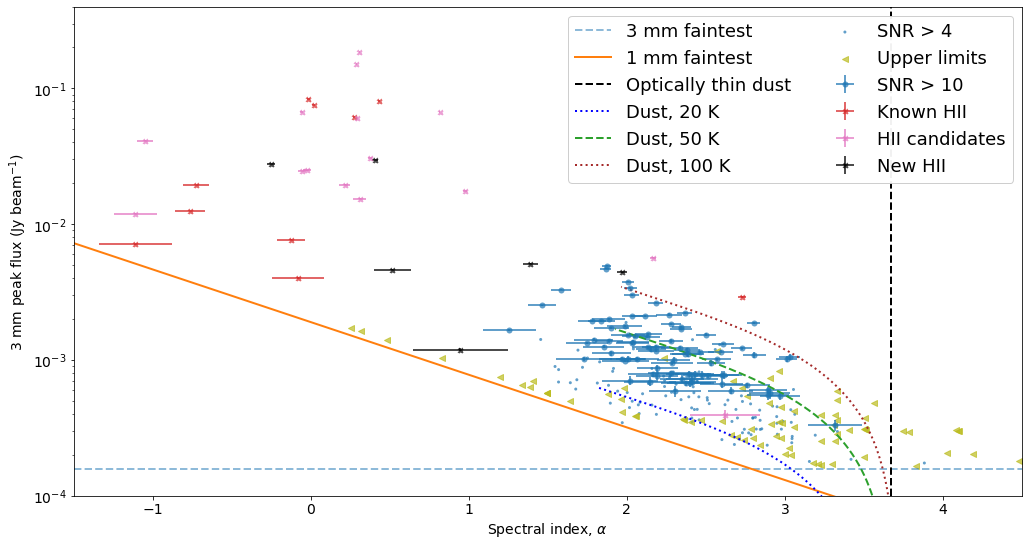

In [26]:
fig = plt.figure(figsize=(17,9))
plt.errorbar(SI_B3_above_10SNR, B3_fluxes_B3, yerr = B3_fluxes_err_B3, xerr = SI_err_B3, alpha = 0.7, markerfacecolor='tab:blue', 
             markeredgecolor='none', linestyle = '', marker = 'o', label = 'SNR > 10')
plt.scatter(SI_B3_above_4SNR, B3_fluxes_B3, alpha = 0.7, edgecolors = 'none', marker = '.', label = 'SNR > 4')
plt.axhline(faint3mm, linestyle = '--', label = '3 mm faintest', alpha = 0.5)
plt.plot(SI_x, B3_corr, label = '1 mm faintest')
plt.axvline(3.67, color = 'k', linestyle = '--', label = 'Optically thin dust')
plt.plot(SI_thin_20, grid_93GHz_20, color = 'Blue', linestyle = ':', label='Dust, 20 K')
plt.plot(SI_thin_50, grid_93GHz_50, color = 'tab:green', linestyle = '--', label='Dust, 50 K')
plt.plot(SI_thin_100, grid_93GHz_100, color = 'brown', linestyle = ':', label='Dust, 100 K')
plt.scatter(SI_limit_B3, B3_fluxes_B3, alpha = 0.7, marker = '<', color = 'tab:olive', label = 'Upper limits')

plt.errorbar(SI_B3_HII_conf_non_limit, B3_fluxes_B3_HII_conf, yerr = B3_fluxes_err_B3_HII_conf, xerr = SI_err_B3_HII_conf, alpha = 0.7, 
             markeredgecolor = 'none', linestyle = '', marker = 'X', label = 'Known HII', color = 'tab:red')

plt.errorbar(SI_B3_HII_cand_non_limit, B3_fluxes_B3_HII_cand, yerr = B3_fluxes_err_B3_HII_cand, xerr = SI_err_B3_HII_cand, alpha = 0.7, 
             markeredgecolor = 'none', linestyle = '', marker = 'X', label = 'HII candidates', color = 'tab:pink')

plt.errorbar(SI_B3_HII_new_non_limit, B3_fluxes_B3_HII_new, yerr = B3_fluxes_err_B3_HII_new, xerr = SI_err_B3_HII_new, alpha = 0.7, 
             markeredgecolor = 'none', linestyle = '', marker = 'X', label = 'New HII', color = 'k')



    
    
plt.yscale('log')
plt.xlabel(r'Spectral index, $\alpha$')
plt.ylabel(r'3 mm peak flux (Jy beam$^{-1}$)')

plt.legend(loc = 'upper right', fontsize = 18, framealpha = 0.95, ncol = 2)
plt.ylim( (10**-4,4*10**-1) )
plt.xlim(-1.5,4.5)
#plt.title('Spectral indexes based on 3 mm detections')
#plt.savefig('B3_fig_final.png',dpi=300,bbox_inches='tight')

(-1.5, 4.5)

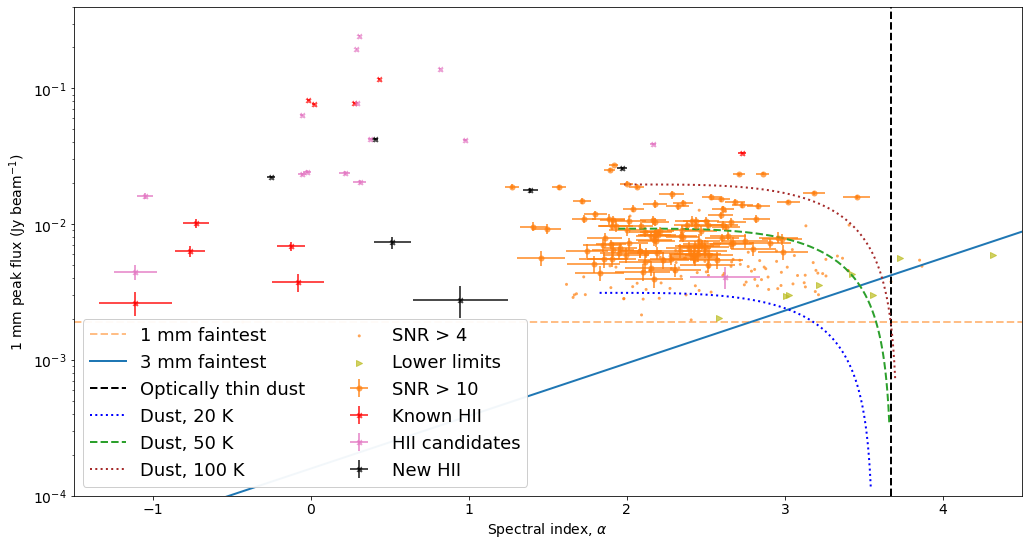

In [27]:
fig = plt.figure(figsize=(17,9))
plt.errorbar(SI_B6_above_10SNR, B6_fluxes_B6, yerr = B6_fluxes_err_B6, xerr = SI_err_B6, alpha = 0.7, linestyle = '', 
             marker = 'o', label = 'SNR > 10', color = 'tab:orange', markerfacecolor='tab:orange', markeredgecolor='none')
plt.scatter(SI_B6_above_4SNR, B6_fluxes_B6, alpha = 0.7, edgecolors = 'none', marker = '.', label = 'SNR > 4', color = 'tab:orange')
plt.axhline(faint1mm, label = '1 mm faintest', linestyle = '--', alpha = 0.5, color = 'tab:orange')
plt.plot(SI_x, B6_corr, label = '3 mm faintest')
plt.axvline(3.67, color = 'k', linestyle = '--', label = 'Optically thin dust')
plt.plot(SI_thin_20, grid_225GHz_20, color = 'Blue', linestyle = ':', label='Dust, 20 K')
plt.plot(SI_thin_50, grid_225GHz_50, color = 'tab:green', linestyle = '--', label='Dust, 50 K')
plt.plot(SI_thin_100, grid_225GHz_100, color = 'brown', linestyle = ':', label='Dust, 100 K')
plt.scatter(SI_limit_B6, B6_fluxes_B6, alpha = 0.7, marker = '>', color = 'tab:olive', label = 'Lower limits')
#
plt.errorbar(SI_B3_HII_conf_non_limit, B6_fluxes_B3_HII_conf, yerr = B6_fluxes_err_B3_HII_conf, xerr = SI_err_B3_HII_conf, alpha = 0.7, 
             markeredgecolor = 'none', linestyle = '', marker = 'X', label = 'Known HII', color = 'r')

plt.errorbar(SI_B3_HII_cand_non_limit, B6_fluxes_B3_HII_cand, yerr = B6_fluxes_err_B3_HII_cand
             , xerr = SI_err_B3_HII_cand, alpha = 0.7, 
             markeredgecolor = 'none', linestyle = '', marker = 'X', label = 'HII candidates', color = 'tab:pink')

plt.errorbar(SI_B3_HII_new_non_limit, B6_fluxes_B3_HII_new, yerr = B6_fluxes_err_B3_HII_new, xerr = SI_err_B3_HII_new, alpha = 0.7, 
             markeredgecolor = 'none', linestyle = '', marker = 'X', label = 'New HII', color = 'k')



plt.xlabel(r'Spectral index, $\alpha$')
plt.ylabel('1 mm peak flux (Jy beam$^{-1}$)')
plt.yscale('log')


plt.legend(loc = 'lower left', fontsize = 18, framealpha = 0.95, ncol = 2)
plt.ylim( (10**-4,4*10**-1) )
plt.xlim(-1.5,4.5)

#plt.savefig('B6_fig_final.png',dpi=300,bbox_inches='tight')

In [28]:
catB3_m = vstack([catNB3_m, catMB3_m])

In [29]:
sigma = 3
SIs_m_bellow_2 = SI_B3_above_10SNR[SI_B3_above_10SNR < 2]
SIs_m_bellow_2_err = SI_err_B3[SI_B3_above_10SNR < 2]
SIs_bellow_signif = SIs_m_bellow_2[(SIs_m_bellow_2 + SIs_m_bellow_2_err*sigma) < 2]

SIs_m_above_2 = SI_B3_above_10SNR[SI_B3_above_10SNR > 2]
SIs_m_above_2_err = SI_err_B3[SI_B3_above_10SNR > 2]
SIs_above_signif = SIs_m_above_2[(SIs_m_above_2 - SIs_m_above_2_err*sigma) > 2]

sigma = 2

SIs_m_bellow_2 = np.where(SI_B3_above_10SNR < 2, SI_B3_above_10SNR, np.nan)

SIs_m_above_2 = np.where(SI_B3_above_10SNR > 2, SI_B3_above_10SNR, np.nan)

SIs_m_2 = SI_B3_above_10SNR[((SIs_m_bellow_2 + (SI_err_B3 * sigma)) > 2) | ((SIs_m_above_2 - (SI_err_B3 * sigma)) < 2)]
catB3_m_SI_2 = catB3_m[((SIs_m_bellow_2 + (SI_err_B3 * sigma)) > 2) | ((SIs_m_above_2 - (SI_err_B3 * sigma)) < 2)]

#SIs_m_2 = SI_B3_above_10SNR[((SI_B3_above_10SNR + (SI_err_B3 * sigma)) > 2) | ((SI_B3_above_10SNR - (SI_err_B3 * sigma)) < 2)]
#catB3_m_SI_2 = catB3_m[((SI_B3_above_10SNR + (SI_err_B3 * sigma)) > 2) | ((SI_B3_above_10SNR - (SI_err_B3 * sigma)) < 2)]

Text(0, 0.5, '$N_{cores}$')

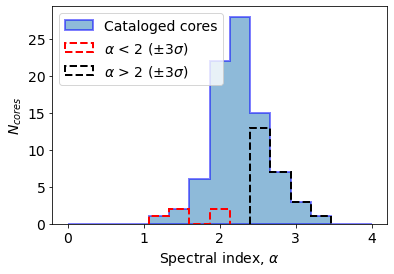

In [30]:
bins = np.linspace(0,4,16)
bins_red = np.linspace(1.06666667, 2.13333333, 5)
bins_black = np.linspace(2.4, 3.46666667, 5)
plt.hist(SI_B3_above_10SNR, alpha = 0.5, bins = bins, histtype = 'stepfilled', ec ='blue', linewidth = 2, label = 'Cataloged cores')
plt.hist(SIs_bellow_signif, alpha = 1, bins = bins_red, histtype = 'step', ec ='red', linewidth = 2, linestyle = '--', label = r'$\alpha$ < 2 ($\pm 3\sigma$)')
plt.hist(SIs_above_signif, alpha = 1, bins = bins_black, histtype = 'step', ec ='k', linewidth = 2, linestyle = '--', label = r'$\alpha$ > 2 ($\pm 3\sigma$)')
#plt.hist([SI_B3_above_10SNR, SI_B3_HII_conf_non_limit, SI_B3_HII_cand_non_limit], bins = bins, stacked = True, 
         #alpha = 0.5, color = ['tab:blue', 'r', 'tab:pink'], histtype = 'stepfilled', linewidth = 2, label = ['Cores', 'HII regions', 'HII region candidates'])
#plt.hist(SI_B3_HII_cand_non_limit, bins = bins)
plt.legend(loc = 'upper left')
#plt.title('Min SNR = 10')
plt.xlabel(r'Spectral index, $\alpha$')
plt.ylabel(r'$N_{cores}$')
#plt.savefig('SI_hist.png', dpi=300,bbox_inches='tight')